In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions.k_means_clustering import kmeans, kmeans_multiple_runs
from metrics.internal_metrics import compute_all_metrics, print_metrics


# K-means Clustering Test - Dortmund


In [2]:
# Load PCA-transformed data (subjects × PCs)
# Note: Use dortmund_pca_transformed.csv (not dortmund_pca_loadings.csv)
data = pd.read_csv('dataset/dortmund_pca_transformed.csv', index_col=0)
features = data.values
subject_ids = data.index.values

print(f"Data shape: {features.shape}")
print(f"Number of subjects: {len(subject_ids)}")
print(f"Number of PCA components: {features.shape[1]}")
print(f"Sample subject IDs: {subject_ids[:3]}")


Data shape: (600, 16)
Number of subjects: 600
Number of PCA components: 16
Sample subject IDs: ['sub-001' 'sub-002' 'sub-003']


[# Single K-means Run


Iteration 0: average loss = 143.796832
Iteration 1: average loss = 91.308380
Iteration 2: average loss = 90.498410
Iteration 3: average loss = 90.322677
Iteration 4: average loss = 90.256092
Iteration 5: average loss = 90.225247
Iteration 6: average loss = 90.188630
Iteration 7: average loss = 90.149035
Iteration 8: average loss = 90.127666
Iteration 9: average loss = 90.098469
Iteration 10: average loss = 90.061792
Iteration 11: average loss = 90.026429
Iteration 12: average loss = 89.965738
Iteration 13: average loss = 89.900000
Iteration 14: average loss = 89.869762
Iteration 15: average loss = 89.829528
Iteration 16: average loss = 89.793762
Iteration 17: average loss = 89.778698
Iteration 18: average loss = 89.762003
Iteration 19: average loss = 89.759781
Iteration 20: average loss = 89.759781
Converged after 21 iterations

Converged: True
Iterations: 21
Final loss: 89.7598
Cluster sizes: [213 200 187]


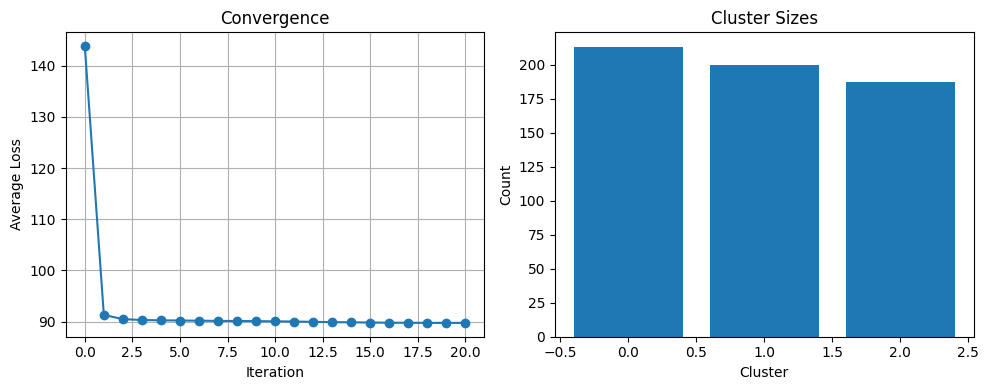

In [3]:
result = kmeans(features, k=3, max_iters=100, threshold=1e-5,
                verbose=True, random_state=42)

print(f"\nConverged: {result['converged']}")
print(f"Iterations: {result['n_iterations']}")
print(f"Final loss: {result['losses'][-1]:.4f}")
print(f"Cluster sizes: {np.bincount(result['assignments'])}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(result['losses'], marker='o')
plt.xlabel('Iteration')
plt.ylabel('Average Loss')
plt.title('Convergence')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(range(len(np.bincount(result['assignments']))),
        np.bincount(result['assignments']))
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Sizes')
plt.tight_layout()
plt.show()


# Internal Validation Metrics


In [4]:
metrics = compute_all_metrics(features, result['assignments'], include_dunn=True)
print_metrics(metrics)


Internal Validation Metrics:
--------------------------------------------------
  Silhouette Score:         0.1158
    Range: [-1, 1], Higher is better
  Davies-Bouldin Index:     2.1628
    Range: [0, ∞), Lower is better
  Calinski-Harabasz Score:  97.2716
    Range: [0, ∞), Higher is better
  Dunn Index:               0.1570
    Range: [0, ∞), Higher is better
  Within-Cluster Variance:  53855.8687
    Lower is better
  Cluster Compactness:
    Cluster 0: 9.7091
    Cluster 1: 8.5558
    Cluster 2: 8.3088


# Multiple Runs


In [34]:
best_result = kmeans_multiple_runs(features, k=10, n_runs=10, max_iters=100,
                                   threshold=1e-5, verbose=False, random_state=42)

print(f"Best run: {best_result['best_run']}")
print(f"Best loss: {best_result['losses'][-1]:.4f}")
print(f"Cluster sizes: {np.bincount(best_result['assignments'])}")

metrics_best = compute_all_metrics(features, best_result['assignments'], include_dunn=False)
print(f"\nBest run metrics:")
print(f"  Silhouette: {metrics_best['silhouette_score']:.4f}")
print(f"  Davies-Bouldin: {metrics_best['davies_bouldin_score']:.4f}")


Best run: 7
Best loss: 66.5791
Cluster sizes: [ 37  50  75  87  58  58  10  37 107  81]

Best run metrics:
  Silhouette: 0.0874
  Davies-Bouldin: 1.9938


# Compare Different K Values - random trying later replaced with optimal k selection (elbow method, ...)


Testing different k values...
k=2: Silhouette=0.17803977577971433, Davies-Bouldin=1.9826
k=3: Silhouette=0.11577896464073788, Davies-Bouldin=2.1628
k=4: Silhouette=0.10261570760656219, Davies-Bouldin=2.2812
k=5: Silhouette=0.08668700651404311, Davies-Bouldin=2.2750
k=6: Silhouette=0.09707850681421971, Davies-Bouldin=2.1072
k=10: Silhouette=0.0861944228410399, Davies-Bouldin=2.0551
k=12: Silhouette=0.07578506257224821, Davies-Bouldin=2.0657


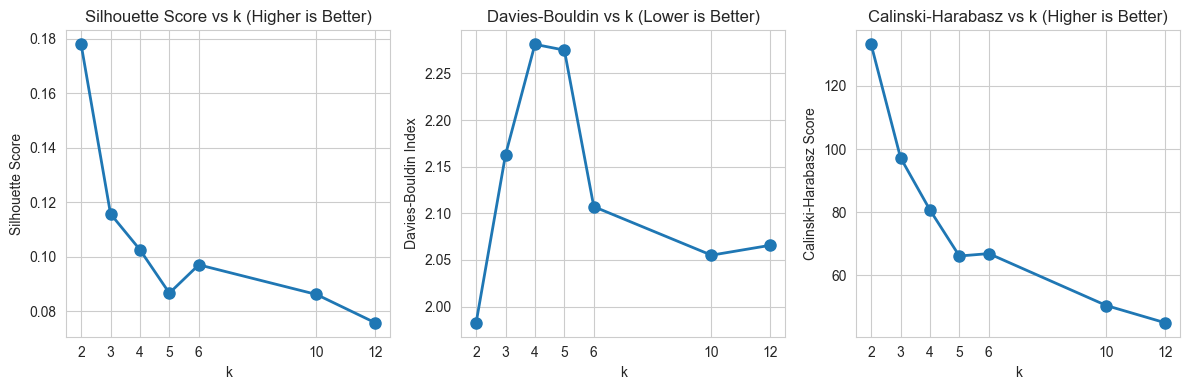

In [14]:
k_values = [2, 3, 4, 5, 6, 10, 12]
results_k = {}

print("Testing different k values...")
for k in k_values:
    result_k = kmeans(features, k=k, max_iters=100, threshold=1e-5,
                     verbose=False, random_state=42)
    metrics_k = compute_all_metrics(features, result_k['assignments'], include_dunn=False)
    results_k[k] = {'result': result_k, 'metrics': metrics_k}
    print(f"k={k}: Silhouette={metrics_k['silhouette_score']}, "
          f"Davies-Bouldin={metrics_k['davies_bouldin_score']:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
silhouettes = [results_k[k]['metrics']['silhouette_score'] for k in k_values]
plt.plot(k_values, silhouettes, 'o-', linewidth=2, markersize=8)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k (Higher is Better)')
plt.grid(True)
plt.xticks(k_values)

plt.subplot(1, 3, 2)
db_scores = [results_k[k]['metrics']['davies_bouldin_score'] for k in k_values]
plt.plot(k_values, db_scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('k')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin vs k (Lower is Better)')
plt.grid(True)
plt.xticks(k_values)

plt.subplot(1, 3, 3)
ch_scores = [results_k[k]['metrics']['calinski_harabasz_score'] for k in k_values]
plt.plot(k_values, ch_scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('k')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz vs k (Higher is Better)')
plt.grid(True)
plt.xticks(k_values)

plt.tight_layout()
plt.show()


# External Validation with Age and Sex


In [20]:
from metrics.external_metrics import (
    one_way_anova,
    two_way_anova,
    print_anova_results,
    load_external_variables,
)

# Load external demographic data (age and sex)
age, sex = load_external_variables('dataset/Dortmund_age&sex.csv', subject_ids)

print(f"Loaded external data:")
print(f"  Age range: {age.min():.0f} - {age.max():.0f} years")
print(f"  Mean age: {age.mean():.1f} ± {age.std():.1f} years")
print(f"  Sex distribution: {np.unique(sex, return_counts=True)}")


Loaded external data:
  Age range: 20 - 70 years
  Mean age: 44.0 ± 14.5 years
  Sex distribution: (array(['F', 'M'], dtype=object), array([370, 230]))


## One-Way ANOVA: Do clusters differ in age?


In [21]:
# Use the best clustering result from multiple runs
anova_result = one_way_anova(age, best_result['assignments'])
print_anova_results(anova_result, test_type="one-way")


ONE-WAY ANOVA: Do clusters differ in mean age?
F-statistic: 14.7028
p-value: 0.0001
Degrees of freedom: (1, 598)
Result: *** HIGHLY SIGNIFICANT (p < 0.001)

Mean age per cluster:
  Cluster 0: 41.54 ± 14.73 years (n=270)
  Cluster 1: 46.07 ± 14.11 years (n=330)


## Two-Way ANOVA: Effects of cluster and sex on age


In [22]:
# Test both cluster and sex effects, plus their interaction
two_way_result = two_way_anova(age, best_result['assignments'], sex)
print_anova_results(two_way_result, test_type="two-way")


TWO-WAY ANOVA: Effects of cluster and sex on age

Main Effect of Cluster:
  F = 14.8352, p = 0.0001
  SIGNIFICANT

Main Effect of Sex:
  F = 6.1361, p = 0.0135
  SIGNIFICANT

Interaction Effect (Cluster × Sex):
  F = 1.2481, p = 0.2644
  NOT SIGNIFICANT

Full ANOVA Table:
       Source            SS  df          MS         F  p-value
      Cluster   3045.949512   1 3045.949512 14.835179 0.000130
          Sex   1259.854620   1 1259.854620  6.136073 0.013521
Cluster × Sex    256.250598   1  256.250598  1.248059 0.264374
     Residual 122370.343604 596  205.319368       NaN      NaN
        Total 126932.398333 599         NaN       NaN      NaN


## Interpretation Guide
- **One-Way ANOVA**: Tests if clusters have different mean ages
  - Significant result (p < 0.05): Clusters are age-related
  - Non-significant: Clusters capture patterns beyond just age → Good!

- **Two-Way ANOVA**: Tests multiple effects
  - **Cluster effect**: Do clusters differ in age (independent of sex)?
  - **Sex effect**: Do males/females differ in age (independent of cluster)?
  - **Interaction**: Does the age-sex relationship vary by cluster?


## Visualize Age Distribution by Cluster


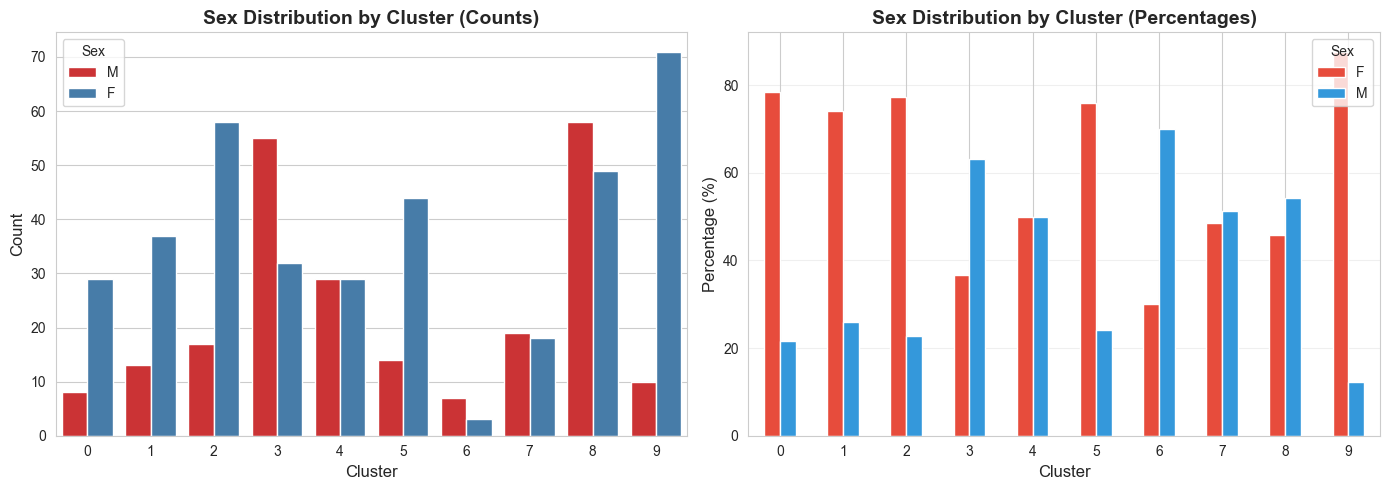

In [35]:
from metrics.external_metrics import plot_sex_distribution

# Plot age distribution by cluster
plot_sex_distribution(sex, best_result['assignments'], plot_type="both")